# Forecasting with statistical models


Statistical models such as ARIMA, SARIMAX, and Exponential Smoothing—have served as the backbone of time series analysis for decades. While machine learning models typically frame forecasting as a tabular regression problem (mapping $X$ to $y$), statistical models are designed to explicitly capture the underlying stochastic processes of a series, including stationarity, seasonality, and autocorrelation

Integrating these traditional methods into the forecasting workflow offers several key advantages:

+ Robustness with Limited Data: Statistical methods often outperform machine learning when historical data is scarce or when the series exhibits a highly stable, dominant seasonal pattern.

+ Interpretability and Simplicity: With fewer parameters and well-understood linear relationships, these models are often easier to explain to stakeholders than "black-box" ensembles.

+ Rigorous Benchmarking: They provide a critical baseline. Before deploying a complex Gradient Boosting Machine (GBM), it is essential to verify if the added complexity provides significant value over a simpler, traditional approach.

+ Probabilistic Foundations: Many statistical models are inherently probabilistic, providing reliable confidence intervals and uncertainty quantification natively.

One of the primary challenges in the Python ecosystem is that statistical libraries often lack a unified API. Unlike the scikit-learn ecosystem, each library typically follows its own convention, making it difficult to switch between models or integrate them into a standardized pipeline. skforecast bridges this gap in two ways:

+ Native Scikit-learn Compatible Implementations: We provide efficient implementations of [`Arima`, `AutoArima`, `SarimaX`](../api/stats.html#skforecast.stats._arima.Arima), [`ETS`](../api/stats.html#skforecast.stats._ets.Ets), and [`ARAR`](../api/stats.html#skforecast.stats._arar.Arar) models that strictly follow the scikit-learn API.

+ The [`ForecasterStats`](../api/forecasterstats.html) Class: This specialized class acts as a wrapper, allowing you to use one or multiple statistical models while leveraging the full power of the skforecast ecosystem—including backtesting, hyperparameter search, and exogenous variable integration.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
To learn more about modeling time series with statistical models, visit our examples:

<ul>
    <li><a href="https://www.cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html">ARIMA and SARIMAX models with Python</a></li>
    <li><a href="https://cienciadedatos.net/documentos/py73-arar-forecasting-models-python">ARAR models with Python</a></li>
    <li><a href="../faq/benchmark-statistical-models.html">Benchmark of statistical models for forecasting</a></li>
</ul>
</p>
</div>

## ForecasterStats

The [`ForecasterStats`](../api/forecasterstats.html) class allows training and validation of ARIMA and SARIMAX models using the skforecast API. `ForecasterStats` is compatible with the [`ARIMA` and `Sarimax` from skforecast](../api/stats.html#skforecast.stats._sarimax.Sarimax) as well as with other implementations, such as [aeon](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.forecasting.stats.ARIMA.html#arima) and [sktime](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.arima.ARIMA.html).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
Since version <b>0.19.0</b> of skforecast, the class <code>ForecasterSarimax</code> has been deprecated in favor of the new class <code>ForecasterStats</code>, which provides improved performance and broader compatibility with statistical models. Users are encouraged to transition to <code>ForecasterStats</code> for future projects.

</p>
</div>

## Libraries and data

In [37]:
# Libraries
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Sarimax
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, grid_search_stats
from skforecast.plot import set_dark_theme
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = 'datetime'

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 3 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


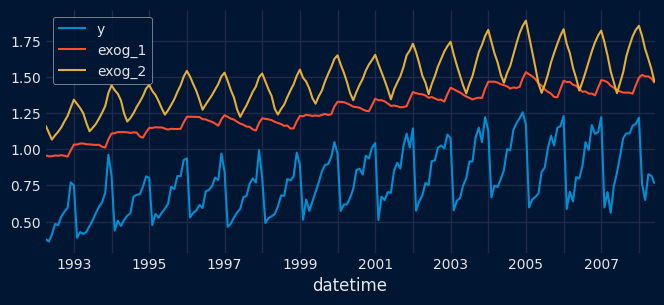

In [39]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend();

## Statsmodels and skforecast

The following section focus on how to train an ARIMA model and forecast future values with each of the three libraries.

<font size="5">**skforecast**</font>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
Skforecast's ARIMA implementation is optimized for speed using just-in-time compilation with Numba. This makes that the first fit of the model is slower due to the compilation process, but subsequent fits and predictions are significantly faster compared to other libraries.
</p>
</div>

In [40]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
arima = Arima(order=(1, 1, 1))
arima.fit(y=data_train['y'])
arima.summary()

ARIMA Model Summary
Model: Arima(1,1,1)
Method: ARIMA(1,1,1)(0,0,0)[1]
Converged: True

Coefficients:
------------------------------------------------------------
  ar1            :     0.6247  (SE:   0.0666, t:     9.38)
  ma1            :    -0.9557  (SE:   0.0228, t:   -41.89)

Model fit statistics:
  sigma^2:             0.018482
  Log-likelihood:      89.58
  AIC:                 -173.16
  BIC:                 N/A

Residual statistics:
  Mean:                0.019372
  Std Dev:             0.134551
  MAE:                 0.091622
  RMSE:                0.135519

Time Series Summary Statistics:
Number of observations: 159
  Mean:                 0.7471
  Std Dev:              0.2068
  Min:                  0.3618
  25%:                  0.5781
  Median:               0.7254
  75%:                  0.8955
  Max:                  1.2572


In [41]:
# Prediction
# ==============================================================================
predictions = arima.predict(steps=12)
predictions

array([0.85926607, 0.8698885 , 0.87652471, 0.8806706 , 0.88326068,
       0.8848788 , 0.8858897 , 0.88652124, 0.88691579, 0.88716228,
       0.88731627, 0.88741247])

<font size="5">**statsmodels**</font>

In [42]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
arima = SARIMAX(endog = data_train['y'], order = (1, 1, 1))
arima_res = arima.fit(disp=0)
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  89.934
Date:                Wed, 28 Jan 2026   AIC                           -173.869
Time:                        12:21:08   BIC                           -164.681
Sample:                    04-01-1992   HQIC                          -170.137
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6316      0.143      4.420      0.000       0.352       0.912
ma.L1         -0.9535      0.054    -17.815      0.000      -1.058      -0.849
sigma2         0.0186      0.002      8.619      0.000       0.014       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               167.05
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# Prediction
# ==============================================================================
predictions = arima_res.get_forecast(steps=12)
predictions.predicted_mean.head(4)

2005-07-01    0.859454
2005-08-01    0.870312
2005-09-01    0.877170
2005-10-01    0.881502
Freq: MS, Name: predicted_mean, dtype: float64

## ForecasterStats

The previous section introduced the construction of ARIMA-SARIMAX models using three different implementations. In order to seamlessly integrate these models with the various functionalities provided by **skforecast**, the next step is to encapsulate the model within a [`ForecasterStats`](../api/forecasterstats.html) object. This encapsulation harmonizes the intricacies of the model and allows for the coherent use of skforecast's extensive capabilities.

## Training

In [44]:
# Create and fit ForecasterStats
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Sarimax'] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Sarimax: 
        {'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': None,
        'measurement_error': False, 'time_varying_regression': False,
        'mle_regression': True, 'simple_differencing': False,
        'enforce_stationarity': True, 'enforce_invertibility': True,
        'hamilton_representation': False, 'concentrate_scale': False,
        'trend_offset': 1, 'use_exact_diffuse': False, 'dates': None,
        'freq': None, 'missing': 'none', 'validate_specification': True,
        'method': 'lbfgs', 'maxiter': 200, 'start_params': None, 'disp':
        False, 'sm_init_kwargs': {}, 'sm_fit_kwargs': {},
        'sm_predict_kwargs': {}} 
fit_kwargs: None 
Creation date: 2026-01-28 12:21:08 
Last fit date: 2026-01-28 12:21:19 
Index seen by the forecaster: DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01'],
              dtype='datetime64[ns]', name='datetime', length=159, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

## Prediction

In [45]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.957912
2005-08-01    0.960128
2005-09-01    1.108638
Freq: MS, Name: pred, dtype: float64

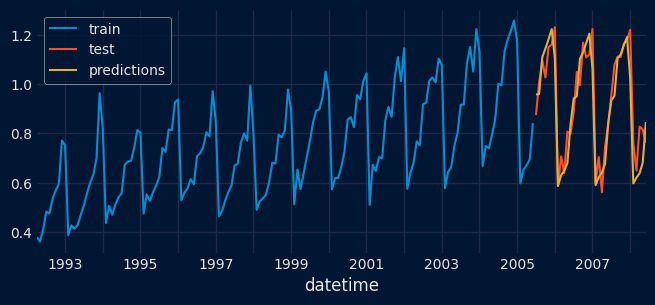

In [46]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [47]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07122719008683308


## Interval prediction

Either `alpha` or `interval` can be used to indicate the confidence of the estimated prediction interval.

In [48]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.957912,0.857879,1.057944
2005-08-01,0.960128,0.853896,1.066360
2005-09-01,1.108638,0.998236,1.219040


## Exogenous variables

The addition of exogenous variables is done using the `exog` argument. The only requirement for including an exogenous variable is the need to know the value of the variable also during the forecast period.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [49]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )
predictions.head(3)

2005-07-01    0.904099
2005-08-01    0.931498
2005-09-01    1.088551
Freq: MS, Name: pred, dtype: float64

## Using an already trained ARIMA

Forecasting with an ARIMA model becomes challenging when the forecast horizon data does not immediately follow the last observed value during the training phase. This complexity is due to the moving average (MA) component, which relies on past forecast errors as predictors. Thus, to predict at time 't', the error of the 't-1' prediction becomes a necessity. In situations where this prediction isn't available, the corresponding error remains unavailable.

For this reason, in most cases, ARIMA models are retrained each time predictions need to be made. Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase. This technique enables the estimation of intermediate predictions and, as a result, the necessary errors.

For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. When generating new predictions, only the 20 most recent values would be needed, rather than the complete historical dataset (365 * 3 + 20).

Integrating new data into the model can be complex, but the <code>ForecasterStats</code> class simplifies this considerably by automating the process through the `last_window` argument in its `predict` method.

Train dates       : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Last window dates : 2005-07-01 00:00:00 --- 2007-06-01 00:00:00  (n=24)
Test dates        : 2007-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=12)


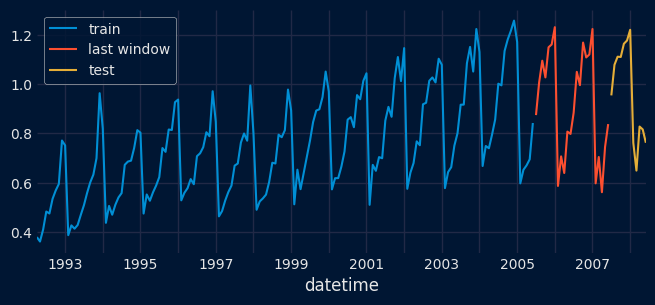

In [50]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = '2005-06-01 23:59:59'
end_last_window = '2007-06-01 23:59:59'

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)
data_train       = data.loc[:end_train]
data_last_window = data.loc[end_train:end_last_window]
data_test        = data.loc[end_last_window:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Since exogenous variables have been included in the Forecaster tuning, it is necessary to pass both past values and their future values to the `predict` method using the `last_window_exog` and `exog` parameters when making predictions.

In [51]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
predictions = forecaster.predict(
                  steps            = 12,
                  exog             = data_test[['exog_1', 'exog_2']],
                  last_window      = data_last_window['y'],
                  last_window_exog = data_last_window[['exog_1', 'exog_2']]
              )
predictions.head(3)

2007-07-01    0.884211
2007-08-01    1.040959
2007-09-01    1.071456
Freq: MS, Name: pred, dtype: float64

In [52]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.06268630745751598


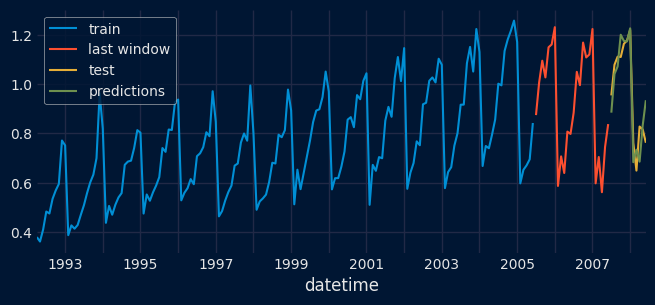

In [53]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Feature importances

Returns the parameters of the model.

In [54]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,exog_2,1.529365
1,ar.L12,0.670760
2,sigma2,0.001591
3,ar.L11,-0.149734
4,ar.L1,-0.161203
5,ar.L5,-0.191176
6,ar.L3,-0.193073
7,ar.L6,-0.209445
8,ar.L9,-0.210317
9,ar.L8,-0.214247


## Backtesting

SARIMAX models can be evaluated using any of the [backtesting strategies](../introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [56]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data['y'],
                          exog              = data[['exog_1', 'exog_2']],
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )

metric

Information of folds
--------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-06-01 00:00:00  (n=171)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-06-01 00:00:00  (n=183)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_absolute_error
0,0.056361


In [57]:
# Backtest predictions
# ======================================================================================
predictions.head(4)

,fold,pred
2005-07-01,0,0.904099
2005-08-01,0,0.931498
2005-09-01,0,1.088551
2005-10-01,0,1.113221


## Model tunning

To find the optimal hyperparameters for the SARIMAX model, the use of strategic search methods is essential. Among these methods, two widely used approaches are:

+ **Statistical Criteria**: Information criterion metrics, such as Akaike's Information Criterion (AIC) or Bayesian Information Criterion (BIC), use different penalties on the maximum likelihood (log-likelihood) estimate of the model as a measure of fit. The advantage of using such criteria is that they are computed only on the training data, eliminating the need for predictions on new data. As a result, the optimization process is greatly accelerated. The well-known Auto Arima algorithm uses this approach.

+ **Validation Techniques**: The use of validation techniques, especially [backtesting](../user_guides/hyperparameter-tuning-and-lags-selection.html), is another effective strategy. Backtesting involves evaluating the performance of the model using historical data to simulate real-world conditions. This helps to validate the effectiveness of the hyperparameters under different scenarios, providing a practical assessment of their viability.

In the first approach, calculations are based solely on training data, eliminating the need for predictions on new data. This makes the optimization process very fast. However, it is important to note that information criteria metrics only measure the relative quality of models. This means that all tested models could still be poor fits. Therefore, the final selected model must undergo a backtesting phase. This phase calculates a metric (such as MAE, MSE, MAPE, etc.) that validates its performance on a meaningful scale.

On the other hand, the second approach - validation techniques - tends to be more time-consuming, since the model must be trained and then evaluated on new data. However, the results generated are often more robust, and the metrics derived can provide deeper insights.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

In summary, while the statistical criteria approach offers speed and efficiency, validation techniques provide a more comprehensive and insightful evaluation, albeit at a slower pace due to their reliance on new data for testing. Fortunately, for sufficiently large data sets, they all lead to the same model.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a unit root test to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/kenburnham/wp-content/uploads/sites/25/2016/08/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

Train dates      : 1992-04-01 00:00:00 --- 2001-01-01 00:00:00  (n=106)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


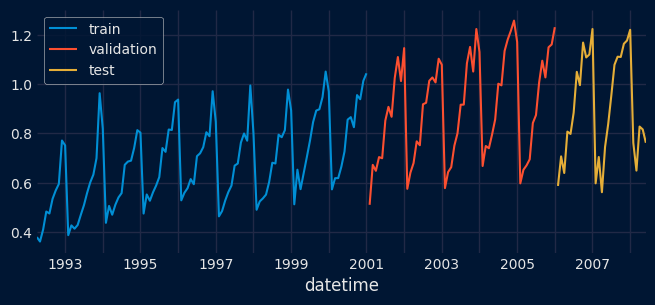

In [58]:
# Train-validation-test data
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:end_val, 'y'].plot(ax=ax, label='validation')
data.loc[end_val:, 'y'].plot(ax=ax, label='test')
ax.legend();

### Grid search with backtesting

In [ ]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), maxiter=200)
             )

param_grid = {
    'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train, 'y']),
         refit              = False
     )

results_grid = grid_search_stats(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   param_grid            = param_grid,
                   cv                    = cv,
                   metric                = 'mean_absolute_error',
                   return_best           = True,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 9.


params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 0), 'trend': 'c'}
  Backtesting metric: 0.058789455086324986



,params,mean_absolute_error,order,trend
0,"{'order': (12, 1, 0), 'trend': 'c'}",0.058789,"(12, 1, 0)",c
1,"{'order': (12, 1, 1), 'trend': 'c'}",0.058871,"(12, 1, 1)",c
2,"{'order': (12, 1, 1), 'trend': 'n'}",0.059517,"(12, 1, 1)",n
3,"{'order': (12, 1, 1), 'trend': None}",0.059517,"(12, 1, 1)",None
4,"{'order': (12, 1, 0), 'trend': 'n'}",0.061720,"(12, 1, 0)",n


Since `return_best = True`, the Forecaster object is updated with the most optimal configuration found and trained with the entire dataset. This means that the grid search will yield the lowest error model with the best hyperparameters that lead to the highest performance metric. This last model can subsequently be utilized for forecasts on new data.

In [ ]:
forecaster

=============== 
ForecasterStats 
=============== 
Estimator: Sarimax(12,1,0)(0,0,0)[0] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    {'concentrate_scale': False, 'dates': None, 'disp': False,
    'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None,
    'hamilton_representation': False, 'maxiter': 200, 'measurement_error':
    False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True,
    'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing':
    False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {},
    'start_params': None, 'time_varying_regression': False, 'trend': 'c',
    'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification':
    True} 
fit_kwargs: {} 
Creation date: 2025-11-26 15:06:20 
Last fit date: 2025-11-26 15:06:46 
Index seen by the forecaster: DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2005-04-01', '2005-05-01', '2005-06-01', '2005-07-01',
               '2005-08-01', '2005-09-01', '2005-10-01', '2005-11-01',
               '2005-12-01', '2006-01-01'],
              dtype='datetime64[ns]', name='datetime', length=166, freq='MS') 
Skforecast version: 0.19.0 
Python version: 3.12.11 
Forecaster id: None

### AutoArima

AutoArima is an algorithm designed to automate the process of selecting the optimal hyperparameters for an ARIMA model. The algorithm systematically evaluates various combinations of the ARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, m) to identify the configuration that best fits the data based on a specified criterion, typically the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

Skforecast's `Arima` class is designed to trigger the AutoArima functionality by simply setting the argument order or seasonal_order to None. Once the model is fitted, the optimal parameters can be accessed through the `best_params_` attribute. When predicting with an AutoArima model, the model use the optimal parameters found during the fitting process.

In [60]:
# AutoArima with skforecast.Arima
# ==============================================================================

auto_arima = Arima(
        order=None,
        seasonal_order=None,
        start_p=0,
        start_q=0,
        max_p=12,
        max_q=3,
        max_P=2,
        max_Q=2,
        max_order=5,
        max_d=2,
        max_D=1,
        ic="aic",
        seasonal=True,
        test="kpss",
        optim_method="BFGS",
        m=12,
        trace=True,
        stepwise=True,
    )
auto_arima.fit(y=data.loc[:end_val, 'y'])


Fitting models using approximations...

 ARIMA(0,0,0)(1,1,1)[12] with drift         : -430.0499
 ARIMA(0,0,0)(0,1,0)[12] with drift         : -407.5866
 ARIMA(1,0,0)(1,1,0)[12] with drift         : -408.2294
 ARIMA(0,0,1)(0,1,1)[12] with drift         : -441.6163
 ARIMA(0,0,0)(0,1,0)[12]                    : -375.7857
 ARIMA(0,0,1)(0,1,0)[12] with drift         : -423.1069
 ARIMA(0,0,1)(1,1,1)[12] with drift         : -444.8451
 ARIMA(0,0,1)(1,1,1)[12]                    : -398.2848
 ARIMA(0,0,1)(1,1,0)[12] with drift         : -429.2924
 ARIMA(0,0,1)(2,1,1)[12] with drift         : -445.8147
 ARIMA(0,0,1)(2,1,1)[12]                    : -396.4248
 ARIMA(0,0,1)(2,1,0)[12] with drift         : -435.0131
 ARIMA(0,0,1)(2,1,2)[12] with drift         : -443.8265
 ARIMA(0,0,1)(1,1,2)[12] with drift         : -444.5276
 ARIMA(0,0,0)(2,1,1)[12] with drift         : -428.9022
 ARIMA(1,0,1)(2,1,1)[12] with drift         : -465.1427
 ARIMA(1,0,1)(2,1,1)[12]                    : Inf
 ARIMA(1,0,1)

,order,None
,seasonal_order,None
,m,12
,include_mean,True
,transform_pars,True
,method,'CSS-ML'
,n_cond,None
,SSinit,'Gardner1980'
,optim_method,'BFGS'
,optim_kwargs,{'maxiter': 1000}
,kappa,1000000.0


## Prediction on training data (In-sample Predictions)

Predictions on the training data are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values wtih the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

The [predictions of the fitted values](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.fittedvalues.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.fittedvalues) are stored in the `fittedvalues` attribute of the `SARIMAXResults` object. This object is stored within the `sarimax_res` attribute of the [skforecast `Sarimax` model](../api/stats.html#skforecast.stats._sarimax.Sarimax):

In [24]:
# Create and fit ForecasterStats (skforecast)
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Sarimax(order=(12, 1, 1), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
forecaster.estimator.sarimax_res.fittedvalues

datetime
1992-04-01    0.000000
1992-05-01    0.379808
1992-06-01    0.361364
1992-07-01    0.413265
1992-08-01    0.481084
                ...   
2005-02-01    0.739315
2005-03-01    0.751082
2005-04-01    0.716096
2005-05-01    0.749931
2005-06-01    0.817595
Freq: MS, Length: 159, dtype: float64